In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, math
from scipy import stats
import os

In [70]:
exponent=1
dir_name = "data_json_hdreshuffle_and_ratio"

# Scale factor vs shuffle amount

In [89]:
def load_network_errors(shuffle_amount, scale_factor):
    randoms = np.arange(10)
    errors = []
    for random in randoms:
        filename = f"hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa{shuffle_amount:1}_sf{scale_factor:1}_e{exponent:.1f}_dp1.0_r{random}"
        filename = f"{dir_name}/{filename}.json"
        if os.path.isfile(filename):
            with open(filename) as f: info = json.load(f)
            errors.append(info["error_distractor"][2])
        else:
            print(f"does not exist: {filename}")
    return np.array(errors)

In [94]:
shuffle_amounts = np.arange(0, 161, 10, dtype="float")
scale_factors = np.arange(1, 4.1, 0.25, dtype="float")
error_means = np.zeros((len(shuffle_amounts), len(scale_factors)), "float")

for i, shuffle_amount in enumerate(shuffle_amounts):
    for j, scale_factor in enumerate(scale_factors):
        errors = load_network_errors(shuffle_amount, scale_factor)
        error_means[i, j] = np.mean(errors)

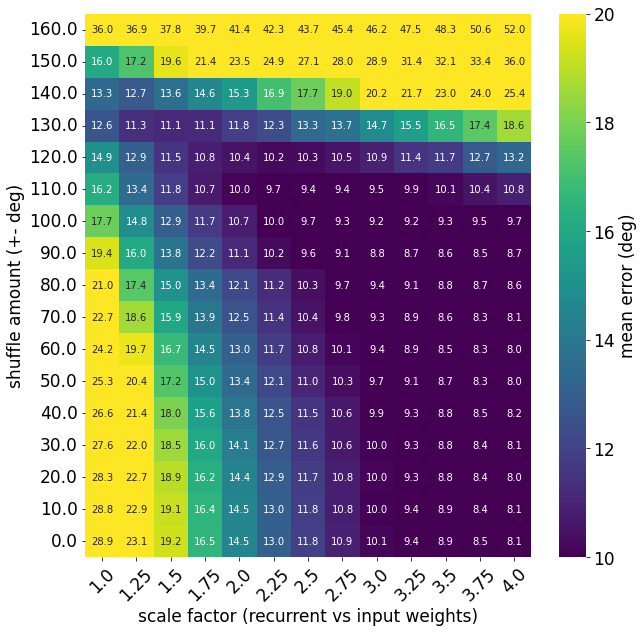

In [95]:
fig = plt.figure(figsize=(10, 10))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ax = sns.heatmap(error_means, cmap="viridis", annot=((error_means*10).astype(int)/10).astype(str), annot_kws={'fontsize': 10}, fmt='s', vmin=10, vmax=20, cbar_kws={'label': 'mean error (deg)'})
ax.invert_yaxis()
ax.set_xticklabels(scale_factors, rotation=45)
ax.set_yticklabels(shuffle_amounts, rotation=0)
ax.set_xlabel("scale factor (recurrent vs input weights)")
ax.set_ylabel("shuffle amount (+- deg)")
plt.show()

# Structural vs Functional Connectivity

In [60]:
shuffle_amount = 80.0
scale_factor = 1.0

def load_structural_functional_connectivity_and_error(shuffle_amount, scale_factor, random):
    filename = f"hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa{shuffle_amount:1}_sf{scale_factor:1}_e{exponent:.1f}_dp1.0_r{random}"
        
    filename1 = f"{dir_name}/{filename}.json"
    if os.path.isfile(filename1):
        with open(filename1) as f: info = json.load(f)
        info = {"error": info["error_distractor"][2]}
    else:
        print(f"does not exist: {filename1}")
        return None

    filename2 = f"{dir_name}/{filename}_connectivity.json"
    if os.path.isfile(filename2):
        with open(filename2) as f: info.update(json.load(f))
    else:
        print(f"does not exist: {filename2}")
        return None
        
    return info

        
factors = np.zeros((len(shuffle_amounts), len(scale_factors), 10, 5), "float") #structural, functional

for i, shuffle_amount in enumerate(shuffle_amounts):
    for j, scale_factor in enumerate(scale_factors):
        for k in range(10):
            res = load_structural_functional_connectivity_and_error(shuffle_amount, scale_factor, k)
            if res is None: continue
            factors[i, j, k] = [res["error"], res["structural_factor"], res["functional_factor"], scale_factor, shuffle_amount]

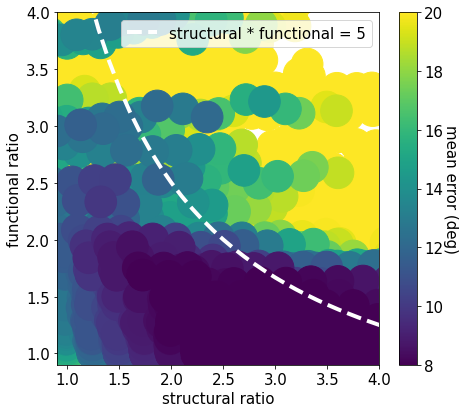

In [61]:
fig = plt.figure(figsize=(4.5*1.5, 4*1.5))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15})

vmin, vmax = 8, 20
x = factors.reshape(-1, 5)[:, 1]
y = factors.reshape(-1, 5)[:, 2]
e = np.clip(factors.reshape(-1, 5)[:, 0], vmin, vmax)

order = np.arange(len(e))
order = np.argsort(e)[::-1]
scatter = plt.scatter(x[order], y[order], 1000, alpha=1, c=e[order], cmap='viridis', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(scatter)
cbar.set_label('mean error (deg)', rotation=270, labelpad=15)

xx = np.linspace(0.1, 10, 100)
plt.plot(xx, 5/xx, "--", color="white", alpha=1, linewidth=4, label="structural * functional = 5")

plt.ylabel("functional ratio")
plt.xlabel("structural ratio")
plt.legend(loc=1)

plt.ylim(.9, 4)
plt.xlim(.9, 4)
plt.tight_layout()
plt.show()

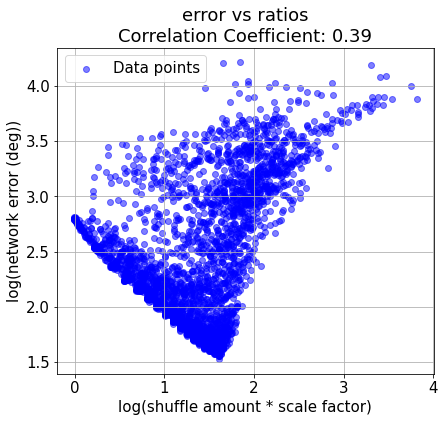

In [62]:
x = factors.reshape(-1, 5)[:, 1]
y = factors.reshape(-1, 5)[:, 2]
e = factors.reshape(-1, 5)[:, 0]
sf = factors.reshape(-1, 5)[:, 3]
sa = factors.reshape(-1, 5)[:, 4]

filter = (e<30) & (x>0.9) & (x<4.1) & (y>0.9) & (y<3.1) & (x*y<4.1)
#filter = (e<30) & (x>0.9) & (x<5.1) & (y>0.9) & (y<5.1) & (x*y<20.1)
filter = np.array([True] * len(e))


t = x[filter]*y[filter]
k = e[filter]

t, k = np.log(t), np.log(k)

fig = plt.figure(figsize=(4.5*1.5, 4*1.5))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15})

# Calculate the best-fit line
#slope, intercept = np.polyfit(t, k, 1)
#line = slope * t + intercept

# Calculate the correlation coefficient
corr_coeff = np.corrcoef(t, k)[0, 1]

# Create a scatter plot
plt.scatter(t, k, label='Data points', color='blue', alpha=0.5)

# Create a line plot for the best-fit line
#plt.plot(t, line, label=f'Best fit: y={slope:.2f}x+{intercept:.2f}', color='red')

# Add labels and a legend
plt.xlabel('log(shuffle amount * scale factor)')
plt.ylabel('log(network error (deg))')
plt.title(f'error vs ratios\nCorrelation Coefficient: {corr_coeff:.2f}')
plt.legend()

#plt.ylim(5, 30)
#plt.xlim(0.5, 15)

# Show the plot
plt.grid(True)
plt.show()

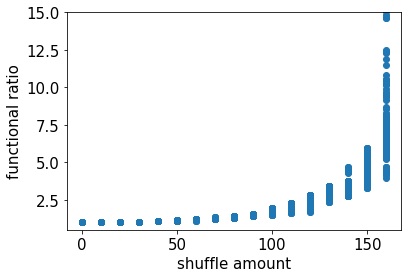

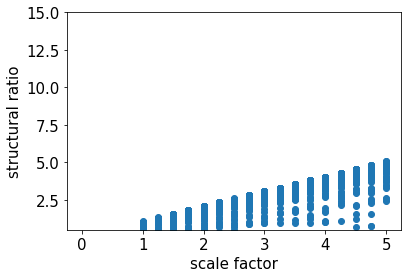

In [45]:
plt.scatter(sa[filter], y[filter])
plt.xlabel("shuffle amount")
plt.ylabel("functional ratio")
plt.ylim(0.5, 15)
plt.show()

plt.scatter(sf[filter], x[filter])
plt.xlabel("scale factor")
plt.ylabel("structural ratio")
plt.ylim(0.5, 15)
plt.show()

In [ ]:
x = factors.reshape(-1, 3)[:, 1]
y = factors.reshape(-1, 3)[:, 2]
e = factors.reshape(-1, 3)[:, 0]

filter = (e<30) & (x>0.9) & (x<4.1) & (y>0.9) & (y<3.1) & (x*y<4.1)
#filter = (e<30) & (x>0.9) & (x<5.1) & (y>0.9) & (y<5.1) & (x*y<20.1)
#filter = np.array([True] * len(e))

t = x[filter]*y[filter]
k = e[filter]

t, k = np.log(t), np.log(k)

fig = plt.figure(figsize=(4.5*1.5, 4*1.5))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15})

# Calculate the best-fit line
slope, intercept = np.polyfit(t, k, 1)
line = slope * t + intercept

# Calculate the correlation coefficient
corr_coeff = np.corrcoef(t, k)[0, 1]

# Create a scatter plot
plt.scatter(t, k, label='Data points', color='blue', alpha=0.5)

# Create a line plot for the best-fit line
#plt.plot(t, line, label=f'Best fit: y={slope:.2f}x+{intercept:.2f}', color='red')

# Add labels and a legend
plt.xlabel('log(functional ratio * structural ratio)')
plt.ylabel('log(network error (deg))')
plt.title(f'error vs ratios\nCorrelation Coefficient: {corr_coeff:.2f}')
plt.legend()

#plt.ylim(5, 30)
#plt.xlim(0.5, 15)

# Show the plot
plt.grid(True)
plt.show()